The process to fine-tune our model is based on Dreambooth:<br>
Ruiz, N., Li, Y., Jampani, V., Pritch, Y., Rubinstein, M., & Aberman, K. (2023). Dreambooth: Fine tuning text-to-image diffusion models for subject-driven generation. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition (pp. 22500-22510).

The following notebook is based on the Dreambooth Tutorial provided on Huggingface: <br>
https://huggingface.co/docs/diffusers/training/dreambooth <br>

# Section 1. Installation of essential libraries and imports

---

In [ ]:
#@title Install the required libs

# first uninstall some librarys because of conflicts
!pip uninstall lida --yes
!pip uninstall tensorflow-probability --yes

# For SDE Schedulers
!pip install torchsde

# probabilistic reasoning and statistical analysis in TensorFlow
!pip install -U tensorflow-probability==0.23.0

# converting Plotly figures to static images
!pip install kaleido

# web framework, handling multipart/form-data, running FastAPI applications
!pip install fastapi python-multipart uvicorn

# Cohere API, interacting with OpenAI, counting tokens without making API call
!pip install cohere openai tiktoken

# repository for diffusers
!pip install -U -qq git+https://github.com/huggingface/diffusers.git

# accelerating code, visualizing training progress, working with transformer models
# fixing Unicode text
!pip install -qq accelerate tensorboard transformers ftfy

# handling binary data
!pip install -qq bitsandbytes
!pip install lida

In [ ]:
!pip install transformers -U

In [ ]:
# @title All necessary Imports

# for Importing Image Files

import pathlib

# for Visualization of Images

from PIL import Image

# Math, Random and Numpy Array Operations

import numpy as np
import math
import random

# access System and Path to Data, File Operations

import os
from pathlib import Path
import shutil

# Pytorch, loss Calculation, gradient checkpointing, Custom Dataset

import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset, DataLoader

# for resizing, normalizing....

from torchvision import transforms

# Load pretrained Model and some Schedulers to try, Scheduler Operations

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
from diffusers import (
    DDPMScheduler,
    PNDMScheduler,
    DDIMScheduler,
    EDMEulerScheduler,
    DEISMultistepScheduler,
    DPMSolverSDEScheduler,
    EulerDiscreteScheduler,
    EulerAncestralDiscreteScheduler,
    KDPM2DiscreteScheduler,
    KDPM2AncestralDiscreteScheduler,
    DPMSolverSinglestepScheduler,
    DPMSolverMultistepScheduler,
    UniPCMultistepScheduler,
    HeunDiscreteScheduler,
    LMSDiscreteScheduler,
    AutoencoderKL,
    StableDiffusionPipeline,
    UNet2DConditionModel,
)

from diffusers.optimization import (
    get_scheduler,
    get_cosine_schedule_with_warmup,
    get_cosine_with_hard_restarts_schedule_with_warmup,
    get_linear_schedule_with_warmup,
    get_polynomial_decay_schedule_with_warmup,
)

# holding Trainingparameters

from argparse import Namespace

# Progress Bar and Garbage Collector

from tqdm import tqdm
import gc

# combining multiple Iterators into a single Iterator

import itertools

# distributed Training

import accelerate
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed

# Optimizers like 8-bit-Adam, AdamW

import bitsandbytes as bnb
from transformers import AdamW


# Abschnitt 2. Funktionen

In [ ]:
# @title Function to later display some previews of our Images


def display_images_as_grid(image_list, rows, cols):
    """
    Create an Imagegrid from a List of Images.

    Parameters:
        image_list (list): List of PIL Images.
        rows (int): Number of Rows of the displayed Grid.
        cols (int): Number of Columns of the displayed Grid.

    Returns:
        img_grid (PIL.Image): An Image Grid containing the PIL Images of the Imagelist.
    """
    # Get the Size of the Images to set Grid Height and Width

    width, height = image_list[0].size

    # Create a new empty Image Grid with the desired Number of Rows and Columns

    img_grid = Image.new(
        'RGB', size=(cols * width, rows * height), color=(255, 255, 255)
    )

    # Paste each Image into the Grid at the correct Position

    [
        img_grid.paste(img, box=(i % cols * width, i // cols * height))
        for i, img in enumerate(image_list)
    ]

    return img_grid


In [ ]:
# @title Function to calculate the best values for Normalize()


def calc_mean_std(images):
    """
    Calculate the Mean and standard Deviation of a Set of PIL Images.

    Parameters:
        images (list): List of PIL Images.

    Returns:
        set_mean (list): List of mean Values for each RGB Channel.
        set_std (list): List of standard Deviation Values for each RGB Channel.
    """
    # Initialize Variables to accumulate Pixelvalues

    channel_sum = np.zeros(3)
    squared_sum = np.zeros(3)
    num_images = len(images)

    # Convert to numpy array, accumulate Pixelvalues

    for img in images:
        img = np.array(img) / 255.0
        channel_sum += np.sum(img, axis=(0, 1))
        squared_sum += np.sum(np.square(img), axis=(0, 1))

    # Calculate Mean and standard Deviation

    set_mean = channel_sum / (num_images * img.shape[0] * img.shape[1])
    set_std = np.sqrt(
        (squared_sum / (num_images * img.shape[0] * img.shape[1])) - np.square(set_mean)
    )

    return set_mean.tolist(), set_std.tolist()


# Section 3. Load the Dataset

In [ ]:
# load the dataset

# ignore git LFS files (to large to handle here)
!git config --global filter.lfs.smudge "git-lfs smudge --skip -- %f"
!git config --global filter.lfs.process "git-lfs filter-process --skip"
# clone repository to access image data
!git clone https://github.com/ukuhl/GenGapCHIRA2024 GenGapCHIRA2024_ressources

instance_imgs_path='GenGapCHIRA2024_ressources/GenGap_dreambooth/instance-images'
file_names = list(pathlib.Path('GenGapCHIRA2024_ressources/GenGap_dreambooth/instance-images').glob('*.jpg'))
####image_paths = [os.path.join(instance_imgs_path, file_name) for file_name in file_names]
# Load Images
images = [Image.open(file_name).convert('RGB') for file_name in file_names]

print(images)

In [ ]:
#@title calculate mean,std for Normalization

# Dataset Mean and standard Deviation

set_mean, set_std = calc_mean_std(images)

# Look at Mean and Std

print('Mean:', set_mean)
print('Standard Deviation:', set_std)


Mean: [0.532568597138718, 0.49788897811476723, 0.48320440502134737]
Standard Deviation: [0.2702251008648049, 0.26332604420811, 0.2680521057963246]


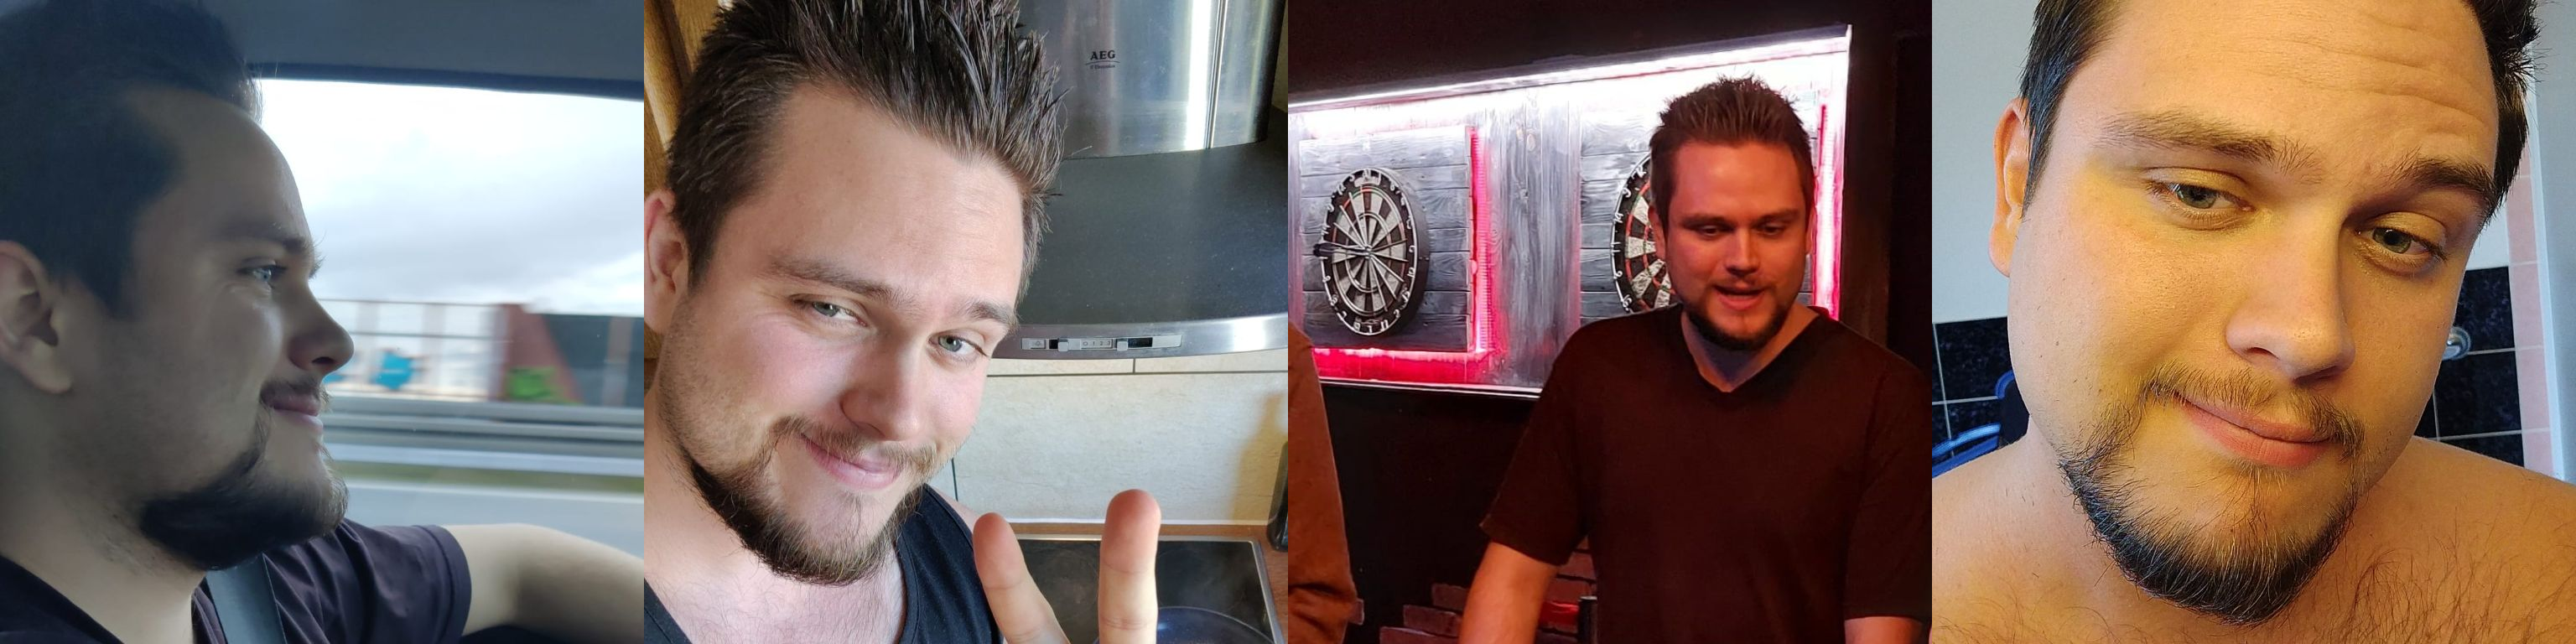

In [ ]:
# @title Display some preview Images


# Number of Images to display

num_images_to_display = 4

# Call the display_images_as_grid Function to create a Grid of preview Instanceimages

display_images_as_grid(images[:num_images_to_display], 1, num_images_to_display)


# Section 4. Class Implementations

In [ ]:
# @title Create Class for the Prompt


class PromptDataset(Dataset):
    def __init__(self, prompt, num_samples):
        """
        Initialize the PromptDataset.

        Parameters:
            prompt (str): The specific Prompt to use for all Samples.
            num_samples (int): Number of Samples in the Dataset.
        """
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        """
        Return the Number of Samples in the Dataset.

        Returns:
            int: Number of Samples.
        """
        return self.num_samples

    def __getitem__(self, index):
        """
        Generate a Sample from the Dataset.

        Parameters:
            index (int): Index of the Sample.

        Returns:
            sample (dict): A Dictionary representing the Sample.
        """
        # Use the provided Prompt for all Samples

        selected_prompt = self.prompt

        # Create a Dictionary representing the Sample

        sample = {
            'prompt': selected_prompt,
            'index': index,
        }

        return sample


In [ ]:
# @title Create Class for Dreambooth Dataset


class DreamBoothDataset(Dataset):
    def __init__(
        self,
        instance_prompt,
        instance_data_root,
        tokenizer,
        size=512,
        center_crop=False,
        class_prompt=None,
        class_data_root=None,
    ):
        """
        Initialize the DreamBoothDataset.

        Parameters:
            instance_prompt (str): Prompt for Instanceimages.
            instance_data_root (str): Path to the Directory containing Instanceimages.
            tokenizer (transformers.CLIPTokenizer): Tokenizer for processing Prompts.
            size (int): Size for resizing and cropping Images.
            center_crop (bool): Whether to use center cropping instead of random cropping.
            class_prompt (str): Prompt for Classimages.
            class_data_root (str): Path to the Directory containing Classimages.
        """
        # Dataset Parameters

        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        # Set all Instanceimage Parameters like Path, Prompt, Number of Images

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        # Set all Classimage Parameters like Path, Prompt, Number of Images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(Path(class_data_root).iterdir())
            self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None
        # Image Transformations

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(
                    size, interpolation=transforms.InterpolationMode.BILINEAR
                ),
                (
                    transforms.CenterCrop(size)
                    if center_crop
                    else transforms.RandomCrop(size)
                ),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=set_mean, std=set_std
                ),  # use calculated mean,std
            ]
        )

    def __len__(self):
        """
        Return the Number of Samples in the Dataset.

        Returns:
            int: Number of Samples.
        """
        return self._length

    def __getitem__(self, index):
        """
        Generate a Sample from the Dataset.

        Parameters:
            index (int): Index of the Sample.

        Returns:
            sample (dict): A Dictionary representing the Sample.
        """
        sample = {}

        # Load and preprocess the Instanceimage

        instance_image_path = self.instance_images_path[
            index % self.num_instance_images
        ]
        try:
            instance_image = Image.open(instance_image_path).convert('RGB')
            instance_image = self.image_transforms(instance_image)
        except Exception as e:
            print(f'Error loading instance image at {instance_image_path}: {e}')
            return None
        sample['instance_images'] = instance_image

        # Tokenize Instanceprompt

        sample['instance_prompt_ids'] = self.tokenizer(
            self.instance_prompt,
            padding='do_not_pad',
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        # Load and preprocess the Classimages

        if self.class_data_root:
            class_image_path = random.choice(self.class_images_path)
            try:
                class_image = Image.open(class_image_path).convert('RGB')
                class_image = self.image_transforms(class_image)
            except Exception as e:
                print(f'Error loading class image at {class_image_path}: {e}')
                return None
            sample['class_images'] = class_image

            # Tokenize Classprompt

            sample['class_prompt_ids'] = self.tokenizer(
                self.class_prompt,
                padding='do_not_pad',
                truncation=True,
                max_length=self.tokenizer.model_max_length,
            ).input_ids
        return sample


In [ ]:
# @title Class to load the pretrained Model


class PretrainedModelsLoader:
    def __init__(self, pretrained_model_name):
        """
        Initialize the PretrainedModelsLoader.

        Parameters:
            pretrained_model_name (str): Name of the pretrained Model.
        """
        self.pretrained_model_name = pretrained_model_name

    def load_text_encoder(self):
        """
        Load the CLIP Textencodermodel.

        Returns:
            transformers.CLIPTextModel: The loaded CLIP Textencodermodel.
        """
        return CLIPTextModel.from_pretrained(
            self.pretrained_model_name, subfolder='text_encoder'
        )

    def load_vae(self):
        """
        Load the VAE (Variational Autoencoder) Model.

        Returns:
            diffusers.AutoencoderKL: The loaded VAE Model.
        """
        return AutoencoderKL.from_pretrained(
            self.pretrained_model_name, subfolder='vae'
        )

    def load_unet(self):
        """
        Load the UNet (2D Conditional) Model.

        Returns:
            diffusers.UNet2DConditionModel: The loaded UNet Model.
        """
        return UNet2DConditionModel.from_pretrained(
            self.pretrained_model_name, subfolder='unet'
        )

    def load_tokenizer(self):
        """
        Load the CLIPTokenizer for Text processing.

        Returns:
            transformers.CLIPTokenizer: The loaded CLIPTokenizer.
        """
        return CLIPTokenizer.from_pretrained(
            self.pretrained_model_name, subfolder='tokenizer'
        )


In [ ]:
# @title Class to create Class Images to concatenate later


class ClassImageGenerator:
    def __init__(self, args, pipeline):
        """
        Initialize the ClassImageGenerator.

        Parameters:
            args (Namespace): Trainingconfiguration Arguments.
            pipeline (diffusers.StableDiffusionPipeline): Pre-trained Diffusionmodel Pipeline.
        """
        self.args = args
        self.pipeline = pipeline

    def generate_class_images(self):
        """
        Generate Classimages based on the provided Configuration.

        This Method generates Classimages using the pretrained Modelpipeline
        and saves the Images to the specified Directory.
        """
        # Set up Classimages Directory

        class_images_dir = Path(self.args.class_data_dir)
        class_images_dir.mkdir(parents=True, exist_ok=True)

        # Check if more Classimages are needed

        num_existing_class_images = len(list(class_images_dir.iterdir()))
        num_new_images = max(0, self.args.num_class_images - num_existing_class_images)

        if num_new_images > 0:
            # Create Dataset for Classimage sampling

            sample_dataset = PromptDataset(self.args.class_prompt, num_new_images)
            sample_dataloader = DataLoader(
                sample_dataset, batch_size=self.args.sample_batch_size
            )

            # Generate and save Classimages

            for sample in tqdm(sample_dataloader, desc='Classimages are generated'):
                images = self.pipeline(sample['prompt']).images

                for idx, image in enumerate(images):
                    # Save Image to the Classimages Directory

                    image.save(
                        class_images_dir
                        / f"{sample['index'][idx] + num_existing_class_images}.jpg"
                    )
            # Clean up Resources

            del sample_dataset
            gc.collect()
            with torch.no_grad():
                torch.cuda.empty_cache()


In [ ]:
# @title create Class for Trainingparameters

class TrainingConfig:
    def __init__(
        self,
        pretrained_model_name,
        instance_imgs_path,
        instance_prompt,
        prior_preservation,
        prior_loss_weight,
        prior_preservation_class_folder,
        prior_preservation_class_prompt,
        num_class_images,
    ):
        """
        Initialize the TrainingConfig Class.

        Parameters:
            pretrained_model_name (str): Name of the pre-trained Model.
            instance_imgs_path (str): Path to the Folder containing the Instanceimages.
            instance_prompt (str): Prompt for the Instanceimages.
            prior_preservation (bool): Flag indicating whether to use
                                       prior preservation.
            prior_loss_weight (float): Weight of the prior preservation Loss.
            prior_preservation_class_folder (str): Path to the Folder containing
                                                   Classimages for prior preservation.
            prior_preservation_class_prompt (str): Prompt for Classimages
            num_class_images (int): Number of Classimages to generate.
        """
        self.pretrained_model_name = pretrained_model_name
        self.instance_imgs_path = instance_imgs_path
        self.instance_prompt = instance_prompt
        self.prior_preservation = prior_preservation
        self.prior_loss_weight = prior_loss_weight
        self.prior_preservation_class_folder = prior_preservation_class_folder
        self.prior_preservation_class_prompt = prior_preservation_class_prompt
        self.num_class_images = num_class_images

    def to_namespace(self):
        """
        Convert the TrainingConfig Instance to a Namespace Object.

        Returns:
            args (Namespace): A Namespace Object containing the Trainingconfiguration.
        """
        return Namespace(
            pretrained_model_name=self.pretrained_model_name,
            resolution=vae.sample_size,
            instance_data_dir=self.instance_imgs_path,
            instance_prompt=self.instance_prompt,
            class_data_dir=self.prior_preservation_class_folder,
            class_prompt=self.prior_preservation_class_prompt,
            num_class_images=self.num_class_images,
            max_train_steps=5000,
            save_steps=5000,
            sample_batch_size=1,
            train_batch_size=1 if self.prior_preservation else 2,
            gradient_accumulation_steps=1,
            max_grad_norm=1.0,
            mixed_precision='fp16',
            gradient_checkpointing=True,
            use_8bit_adam=True,
            center_crop=True,
            train_text_encoder=True,
            with_prior_preservation=self.prior_preservation,
            prior_loss_weight=self.prior_loss_weight,
            learning_rate=1e-6,
            lr_scheduler='constant',
            lr_warmup_steps=100,
            seed=1,
            output_dir='GenGapCHIRA2024_ressources/GenGapCHIRA2024_trained_model',
        )


training_config = TrainingConfig(
    pretrained_model_name ='runwayml/stable-diffusion-v1-5',
    instance_imgs_path='GenGapCHIRA2024_ressources/GenGap_dreambooth/instance-images',
    instance_prompt='relu96 man',
    prior_preservation=True,
    prior_loss_weight=1.0,
    prior_preservation_class_folder='GenGapCHIRA2024_ressources/GenGap_dreambooth/class-images',
    prior_preservation_class_prompt='a man',
    num_class_images=100,
)

# Sections 5. Settings for Concept and Training

In [ ]:
# @title Load all the Components of the pretrained Model

pretrained_model_name = 'runwayml/stable-diffusion-v1-5'

# Create an Instance of PretrainedModelsLoader

models_loader = PretrainedModelsLoader(pretrained_model_name)

# Load individual Components

text_encoder = models_loader.load_text_encoder()
vae = models_loader.load_vae()
unet = models_loader.load_unet()
tokenizer = models_loader.load_tokenizer()


text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/606 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

In [ ]:
#@title Setup all Trainingargs


# Load all Arguments

args = training_config.to_namespace()


<ipython-input-86-12248ec19bb6>:49: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  resolution=vae.sample_size,


# Section 6. Create Class images to learn our Concept on

In [ ]:
# @title Create some Class Images

# Create the Stable Diffusion Pipeline for generating Classimages

class_image_pipeline = StableDiffusionPipeline.from_pretrained(
    args.pretrained_model_name, torch_dtype=torch.float16,
    scheduler=DPMSolverMultistepScheduler.from_pretrained(
        args.pretrained_model_name, subfolder='scheduler', use_karras_sigmas=True
    )
).to('cuda')

class_image_pipeline.safety_checker = None

# Enable Attentionslicing for efficient Processing

class_image_pipeline.enable_attention_slicing()

# Initialize the ClassImageGenerator with the configured Pipeline

class_image_generator = ClassImageGenerator(args, class_image_pipeline)

# Generate Classimages based on the provided Configuration

class_image_generator.generate_class_images()


## ALTERNATIVE: Load class images used in study:
#
#class_imgs_path='GenGapCHIRA2024_ressources/GenGap_dreambooth/class-images'
#file_names = list(pathlib.Path('GenGapCHIRA2024_ressources/GenGap_dreambooth/class-images').glob('*.jpg'))
## Load Images
#class_images = [Image.open(file_name).convert('RGB') for file_name in file_names]
#
## Display some preview Images
## Number of Images to display
#num_images_to_display = 4
#
## Call the display_images_as_grid Function to create a Grid of preview Instanceimages
#display_images_as_grid(class_images[:num_images_to_display], 1, num_images_to_display)

scheduler/scheduler_config.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Classimages are generated:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Classimages are generated:   1%|          | 1/100 [00:19<32:20, 19.61s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:   2%|▏         | 2/100 [00:38<30:51, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:   3%|▎         | 3/100 [00:56<30:17, 18.74s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:   4%|▍         | 4/100 [01:15<30:06, 18.82s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:   5%|▌         | 5/100 [01:34<29:59, 18.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:   6%|▌         | 6/100 [01:53<29:38, 18.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:   7%|▋         | 7/100 [02:12<29:15, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:   8%|▊         | 8/100 [02:31<28:52, 18.83s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:   9%|▉         | 9/100 [02:49<28:33, 18.83s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  10%|█         | 10/100 [03:08<28:16, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  11%|█         | 11/100 [03:27<27:59, 18.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  12%|█▏        | 12/100 [03:46<27:40, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  13%|█▎        | 13/100 [04:05<27:21, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  14%|█▍        | 14/100 [04:24<27:01, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  15%|█▌        | 15/100 [04:43<26:42, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  16%|█▌        | 16/100 [05:01<26:23, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  17%|█▋        | 17/100 [05:20<26:05, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  18%|█▊        | 18/100 [05:39<25:47, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  19%|█▉        | 19/100 [05:58<25:27, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  20%|██        | 20/100 [06:17<25:08, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  21%|██        | 21/100 [06:36<24:48, 18.84s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  22%|██▏       | 22/100 [06:55<24:29, 18.84s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  23%|██▎       | 23/100 [07:13<24:11, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  24%|██▍       | 24/100 [07:32<23:53, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  25%|██▌       | 25/100 [07:51<23:35, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  26%|██▌       | 26/100 [08:10<23:16, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  27%|██▋       | 27/100 [08:29<22:56, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  28%|██▊       | 28/100 [08:48<22:37, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  29%|██▉       | 29/100 [09:07<22:18, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  30%|███       | 30/100 [09:25<21:59, 18.84s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  31%|███       | 31/100 [09:44<21:40, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  32%|███▏      | 32/100 [10:03<21:22, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  33%|███▎      | 33/100 [10:22<21:03, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  34%|███▍      | 34/100 [10:41<20:44, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  35%|███▌      | 35/100 [11:00<20:25, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  36%|███▌      | 36/100 [11:19<20:06, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  37%|███▋      | 37/100 [11:37<19:47, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  38%|███▊      | 38/100 [11:56<19:28, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  39%|███▉      | 39/100 [12:15<19:10, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  40%|████      | 40/100 [12:34<18:51, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  41%|████      | 41/100 [12:53<18:32, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  42%|████▏     | 42/100 [13:12<18:13, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  43%|████▎     | 43/100 [13:31<17:54, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  44%|████▍     | 44/100 [13:49<17:35, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  45%|████▌     | 45/100 [14:08<17:16, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  46%|████▌     | 46/100 [14:27<16:57, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  47%|████▋     | 47/100 [14:46<16:39, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  48%|████▊     | 48/100 [15:05<16:20, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  49%|████▉     | 49/100 [15:24<16:01, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  50%|█████     | 50/100 [15:43<15:42, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  51%|█████     | 51/100 [16:01<15:24, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  52%|█████▏    | 52/100 [16:20<15:05, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  53%|█████▎    | 53/100 [16:39<14:46, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  54%|█████▍    | 54/100 [16:58<14:27, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  55%|█████▌    | 55/100 [17:17<14:08, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  56%|█████▌    | 56/100 [17:36<13:49, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  57%|█████▋    | 57/100 [17:55<13:31, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  58%|█████▊    | 58/100 [18:13<13:11, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  59%|█████▉    | 59/100 [18:32<12:52, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  60%|██████    | 60/100 [18:51<12:34, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  61%|██████    | 61/100 [19:10<12:15, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  62%|██████▏   | 62/100 [19:29<11:56, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  63%|██████▎   | 63/100 [19:48<11:37, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  64%|██████▍   | 64/100 [20:07<11:18, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  65%|██████▌   | 65/100 [20:25<10:59, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  66%|██████▌   | 66/100 [20:44<10:41, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  67%|██████▋   | 67/100 [21:03<10:22, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  68%|██████▊   | 68/100 [21:22<10:03, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  69%|██████▉   | 69/100 [21:41<09:44, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  70%|███████   | 70/100 [22:00<09:25, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  71%|███████   | 71/100 [22:18<09:06, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  72%|███████▏  | 72/100 [22:37<08:47, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  73%|███████▎  | 73/100 [22:56<08:28, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  74%|███████▍  | 74/100 [23:15<08:09, 18.84s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  75%|███████▌  | 75/100 [23:34<07:51, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  76%|███████▌  | 76/100 [23:53<07:32, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  77%|███████▋  | 77/100 [24:12<07:13, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  78%|███████▊  | 78/100 [24:30<06:54, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  79%|███████▉  | 79/100 [24:49<06:36, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  80%|████████  | 80/100 [25:08<06:17, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  81%|████████  | 81/100 [25:27<05:58, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  82%|████████▏ | 82/100 [25:46<05:39, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  83%|████████▎ | 83/100 [26:05<05:20, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  84%|████████▍ | 84/100 [26:24<05:01, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  85%|████████▌ | 85/100 [26:43<04:43, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  86%|████████▌ | 86/100 [27:01<04:24, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  87%|████████▋ | 87/100 [27:20<04:05, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  88%|████████▊ | 88/100 [27:39<03:46, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  89%|████████▉ | 89/100 [27:58<03:27, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  90%|█████████ | 90/100 [28:17<03:08, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  91%|█████████ | 91/100 [28:36<02:49, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  92%|█████████▏| 92/100 [28:55<02:30, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  93%|█████████▎| 93/100 [29:13<02:11, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  94%|█████████▍| 94/100 [29:32<01:53, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  95%|█████████▌| 95/100 [29:51<01:34, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  96%|█████████▌| 96/100 [30:10<01:15, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  97%|█████████▋| 97/100 [30:29<00:56, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  98%|█████████▊| 98/100 [30:48<00:37, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated:  99%|█████████▉| 99/100 [31:07<00:18, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Classimages are generated: 100%|██████████| 100/100 [31:25<00:00, 18.86s/it]


If you want to experiment with creating good class images, you can run the next cell to delete the class image folder. This allows you to create new class images with different schedulers and other parameters until you are satisfied with the results. Keep in mind that good class images are just as important as the instance images. Instance and class images are combined and fed back into the model to train it on your concept. If either your instance or class images are of poor quality, you will achieve subpar results.

In [ ]:
##@title Delete Class Images
#
## Specify the Path to the Folder you want to delete
#
#delete_path = '/content/class_images'
#
## Use shutil.rmtree() to delete the Folder and its Contents
#
#shutil.rmtree(delete_path)

# Section 7. Training Function and Training

In [ ]:
#@title Functions for Training


def set_up_accelerator():
    """
    Initialize the Accelerator from accelerate.

    Parameters:
        None

    Returns:
        accelerator (Accelerator): The initialized Accelerator Object.
    """

    accelerator = Accelerator(
        split_batches=False,
        mixed_precision=args.mixed_precision,
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        step_scheduler_with_optimizer=True,
        use_seedable_sampler=False,
    )

    return accelerator

def set_up_optimizer():
    """
    Choose the Optimizer based on the Trainingconfig. Chooses between
    AdamW and 8bitAdamW.

    Parameters:
        None

    Returns:
        optimizer: The initialized optimizer object. It can be either be an Instance of
                   bnb.8bitAdamW or transformers.AdamW.
    """

    if args.use_8bit_adam:
        class_of_optimizer = bnb.optim.AdamW8bit
    else:
        class_of_optimizer = torch.optim.AdamW

    # Define the Parameters to Optimize if we are training the Textencoder
    # also optimize it otherwise only the unet

    if args.train_text_encoder:
        params_to_optimize = itertools.chain(
            unet.parameters(), text_encoder.parameters()
        )
    else:
        params_to_optimize = unet.parameters()

    # Initialize the Optimizer with the Parameters we want to optimize
    # and the choosen Leraningrate from our Trainingconfig

    optimizer = class_of_optimizer(params_to_optimize, lr=args.learning_rate)

    return optimizer

def freeze_parameters():
    """
    Freeze Vae and/or text Encoder if you dont want to train it
    this means it wont compute Gradients for those Parameters during backward Pass
    but still be able to do Computations during forward Pass.

    Parameters:
        None

    Returns:
        None
    """

    vae.requires_grad_(False)

    if not args.train_text_encoder:
        text_encoder.requires_grad_(False)

def set_up_gradient_checkpointing():
    """
    Enable Gradient Checkpointing if set. Gradient Checkpointing selectivley recomputes
    certain Activations during backward pass, instead of storing everything in Memory
    during Forwardpass, to reduce Memory Usage.

    Parameters:
        None

    Returns:
        None
    """

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

        # If Gradient Checkpointing is set. Check to enable it on text_encoder

        if args.train_text_encoder:
            text_encoder.gradient_checkpointing_enable()

def set_up_noise_scheduler():
    """
    Load the Scheduler from the Config.Json. The ones that work are DDPM or DDIM.
    Only theese two have the get_velocity() that we later need during Target Calculation.
    The Scheduler will be used to add Noise to the Tensors during Training.

    Parameters:
        None

    Returns:
        noise_scheduler: The initialized noise scheduler object. Either DDPM
                         or DDIM
    """

    noise_scheduler = DDPMScheduler.from_config(
        args.pretrained_model_name, subfolder="scheduler"
    )

    return noise_scheduler

def set_up_lr_scheduler(optimizer):
    """
    Initialize the Learningrate Scheduler. The Learningrate Scheduler is used to adjust
    the Learningrate during Training. If you want to keep it 'constant' or adjust it
    to improve or avoid Convergence.

    Parameters:
        optimizer: The initialized Optimizer Object. It can be either be an Instance of
                   bnb.8bitAdamW or transformers.AdamW.

    Returns:
        lr_scheduler: The initialized Learningrate Scheduler Object.
    """

    get_scheduler_list = [
        'linear',
        'cosine',
        'cosine_with_restarts',
        'polynomial',
        'constant',
        'constant_with_warmup',
        'piecewise_constant'
    ]

    special_scheduler_dict = {
        'cosine_with_warmup': get_cosine_schedule_with_warmup,
        'cosine_with_hard_restarts': get_cosine_with_hard_restarts_schedule_with_warmup,
        'linear_with_warmup': get_linear_schedule_with_warmup,
        'polynomial_decay_with_warmup': get_polynomial_decay_schedule_with_warmup
    }

    if args.lr_scheduler in get_scheduler_list:
        lr_scheduler = get_scheduler(
            args.lr_scheduler,
            optimizer=optimizer,
            num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
            num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
        )
    elif args.lr_scheduler in special_scheduler_dict:
        lr_scheduler = special_scheduler_dict[args.lr_scheduler](
            optimizer=optimizer,
            num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
            num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
        )

    return lr_scheduler



def collate_fn(samples):
    """
    Concatenate the Instance and Class Images.

    Parameters:
        samples (Dict): The Dict containing the Instance and Classimages

    Returns:
        batch (Dict): The processed Batch containing input_ids and pixel_values Tensors.
    """

    # Get the tokenized Prompt for the instance images and the correlated instance image

    input_ids = [sample['instance_prompt_ids'] for sample in samples]
    pixel_values = [sample['instance_images'] for sample in samples]

    # if we choose to use prior preservation concat instance and class Images

    if args.with_prior_preservation:
        input_ids += [sample['class_prompt_ids'] for sample in samples]
        pixel_values += [sample['class_images'] for sample in samples]

    # create Tensor where each Element corresponds to the Pixelvalues of an Image
    # Change Tensor Type to Float to ensure Operationcompatibility with PyTorch
    # For Example the .add_noise Methode from the Noiseschedulers need a Tensor
    # Float Type to work

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    # Make sure all input Sequences have the same Length

    input_ids = tokenizer.pad(
        {'input_ids': input_ids},
        padding='max_length',
        return_tensors='pt',
        max_length=tokenizer.model_max_length,
    ).input_ids

    # Create new Dict with processed input_ids and the Pixelvalues Tensors
    # if prior Preservation was set it holds the concatenated Instance and
    # Classimages otherwise only the Instanceimages

    batch = {'input_ids': input_ids, 'pixel_values': pixel_values}

    return batch

def set_up_dataset(tokenizer):
    """
    Initialize the DreamboothDataset that holds our Trainingdate as a Dict with Class
    and Instanceimages and there correlated Prompt.

    Parameters:
        okenizer (transformers.ClipTokenizer): The initialized Tokenizer Object

    Returns:
        train_dataset (DreamboothDataset): The initialized Trainingdataset Object.
        train_dataloader (torch.utils.data.DataLoader): The initialized Trainingdataloader Object.
    """

    train_dataset = DreamBoothDataset(
        instance_prompt=args.instance_prompt,
        instance_data_root=args.instance_data_dir,
        tokenizer=tokenizer,
        size=args.resolution,
        center_crop=args.center_crop,
        class_prompt=args.class_prompt,
        class_data_root=args.class_data_dir if args.with_prior_preservation else None,
    )

    # Initialize the Dataloader from torch.utils.data that will have all our
    # Trainingdate. Use the collate Function to concatenate the Instance and
    # Class Images

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=args.train_batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )

    return train_dataset, train_dataloader

def set_up_mixed_precision(accelerator):
    """
    Set up mixed Precision Training. During forward Pass input Data and Parameters
    are stored in half-precision(16-bit) which leads to significant memory Savings.
    During backward Pass the Gradients are also accumulated in half-precision.
    To maintain numerical Stability certain Computations like gradient Updates
    and gradient Clipping are performed in single-precision(32-bit) to prevent
    Overflow or Underflow that can occure with half-precision.

    Parameters:
        accelerator (accelerate.Accelerator): The initialized accelerator Object

    Returns:
        weight_dtype: The weighted Datatype. Can be fp16, bf16 or fp32 as Default
    """

    # Dictionary of precision Types to use

    precision_to_dtype = {
        'fp16': torch.float16,
        'bf16': torch.bfloat16,
    }

    # Check which Type was set in the Accelerator and set the weight to it
    # defaults to float32

    weight_dtype = precision_to_dtype.get(accelerator.mixed_precision, torch.float32)

    return weight_dtype

def prepare_model(
    accelerator, unet, text_encoder, optimizer, train_dataloader, lr_scheduler
):
    """
    Prepare all Model Components for Training using the Accelerator.

    Parameters:
        accelerator (accelerate.Accelerator): The Accelerator Object for distributed Computations.
        unet (diffusers.UNet2DConditionalModel): The U-Net Model to be prepared.
        text_encoder (transformers.ClipTextModel): The Textencoder Model to be prepared.
        optimizer: The initialized Optimizer Object. It can be either be an Instance of
                   bnb.8bitAdamW or transformers.AdamW.
        train_dataloader (torch.utils.data.DataLoader): The Trainingdataloader.
        lr_scheduler: The Learningrate Scheduler object.

    Returns:
    tuple: A tuple containing the prepared Model Components.
           unet (diffusers.UNet2DConditionalModel): The prepared U-Net Model.
           text_encoder (transformers.ClipTextModel): The prepared Textencoder Model.
           optimizer: The initialized Optimizer Object. It can be either be an Instance of
                      bnb.8bitAdamW or transformers.AdamW.
           train_dataloader (torch.utils.data.DataLoader): The prepared Trainingdataloader.
           lr_scheduler: The prepared Learningrate Scheduler Object.
    """

    unet, train_dataloader, optimizer, lr_scheduler = accelerator.prepare(
        unet, train_dataloader, optimizer, lr_scheduler
    )

    # Check Trainingconfig if text Encoder should be prepared or not

    if args.train_text_encoder:
        unet, train_dataloader, text_encoder, optimizer, lr_scheduler = (
            accelerator.prepare(
                unet, train_dataloader, text_encoder, optimizer, lr_scheduler
            )
        )

    return unet, text_encoder, optimizer, train_dataloader, lr_scheduler


def move_to_gpu(accelerator, weight_dtype):
    """
    Move the VAE and optionally the Textencoder to GPU even if they are frozen for backward pass.
    Ensures that Computations during the Forwardpass are performed on the GPU for Computational Efficiency.
    The VAE Decoder is moved to the CPU to avoid unnecessary GPU Memory usage.

    Parameters:
        accelerator (accelerate.Accelerator): The Accelerator Object.
        weight_dtype: The Datatype to be used for the Model Weights.
                      Can be fp16, bf16 or fp32

    Returns:
        None
    """

    vae.to(accelerator.device, dtype=weight_dtype)
    vae.decoder.to('cpu')

    if not args.train_text_encoder:
        text_encoder.to(accelerator.device, dtype=weight_dtype)

def calc_train_epochs(train_dataloader):
    """
    Calculates the Number of Trainingepochs based on the Length of the Dataset, gradient accumulation steps,
    maximum Trainingsteps and the Batchsize.

    Parameters:
        train_dataloader (torch.utils.data.DataLoader): The Dataloader containing the Trainingdataset.

    Returns:
        num_train_epochs (int): The calculated Number of Trainingepochs.
    """

    num_samples = len(train_dataloader)
    best_batch_size = args.train_batch_size * args.gradient_accumulation_steps
    batches_each_epoch = math.ceil(num_samples / best_batch_size)
    num_train_epochs = math.ceil(args.max_train_steps / batches_each_epoch)

    # Add an additional Epoch if it happens that there are remaining steps

    if num_train_epochs * batches_each_epoch < args.max_train_steps:
        num_train_epochs += 1

    return num_train_epochs

def set_up_progress_bar(accelerator):
    """
    Initialize a tqdm Progressbar to visualize and keep Track of the
    Trainingprogress.

    Parameters:
        accelerator (accelerate.Accelerator): The Accelerator Object used
                                              for the distributed Training.

    Returns:
    bar, steps_taken (tuple): A Tuple containing the initialized tqdm Progressbar and a
                              Counter to keep Track of how many Steps are already taken
                              during Training.
    """

    if accelerator.is_local_main_process:
        disable_bar = False
    else:
        disable_bar = True

    bar = tqdm(
        desc='Progress',
        total=args.max_train_steps,
        leave=True,
        disable=disable_bar,
        dynamic_ncols=True,
    )

    # Counter to keep track of Steps taken during Training

    steps_taken = 0

    return bar, steps_taken

def image_to_latents(vae, batch, weight_dtype):
    """
    Convert Inputimages using the specified Variational Autoencoder (VAE) to latent Space Vectors.
    It requires the Inputimages to be in
    Pixelvalue Format and converts them to the desired Datatype for Tensor Operations.

    Parameters:
        vae (diffusers.AutoEncoderKl): The Variational Autoencoder Model used for encoding Images.
        batch (dict): A Dictionary containing Pixelvalues of Images.
                      Expected keys: 'pixel_values'
        weight_dtype: The desired Datatype for Tensoroperations. Either fp16, bf16, fp32

    Returns:
        latents (torch.Tensor): Latent space Vectors obtained from encoding the Inputimages.
    """

    latents = vae.encode(
        batch['pixel_values'].to(dtype=weight_dtype)
    ).latent_dist.sample()

    # adjust the Magnitude of the Vectors to a suitable Range

    latents *= 0.18215

    return latents

def sample_noise_timesteps(latents, noise_scheduler):
    """
    Generates random Noise and Timesteps for each Vector in the
    Input.

    Parameters:
        latents (torch.Tensor): Latent Space Vectors for which Noise and Timesteps are
                                generated.
        noise_scheduler: The Noisescheduler Object that provides Configurations
                         for generating Timesteps and add Noise. Either DDPM
                         or DDIM
    Returns:
        noise, timesteps (Tuple[torch.Tensor, torch.Tensor]): A Tuple containing the generated Noise and
                                                              corresponding Timesteps.
    """

    # Generate random Noise that has the same Shape as the Latents

    noise = torch.randn(latents.shape, device=latents.device)

    # Generate random Timesteps for the Noise
    # The Number of Timesteps is given by the config and
    # the Size of the Tensor is determined by the Number of latent Vectors

    timesteps = torch.randint(
        0,
        noise_scheduler.config.num_train_timesteps,
        (latents.shape[0],),
        device=latents.device,
    ).long()

    return noise, timesteps

def calc_target(noise_scheduler, latents, noise, timesteps):
    """
    Calculates the Targetvalue for the Loss based on the
    prediction Type specified in the Noisescheduler's Configuration.

    Parameters:
        noise_scheduler (DDPM, DDIM): The Noisescheduler Object that provides Configurations
                                      for the Target Calculation.
        latents (torch.Tensor): Latent space Vectors.
        noise (torch.Tensor): Random Noise generated for the Latents.
        timesteps (torch.Tensor): Random Timesteps associated with the given Noise.

    Returns:
        target (torch.Tensor): The Targetvalue for the Losscomputation.
    """

    # Calculate the Target Value for the Loss Computation from the Schedulers
    # Config Prediction Type

    prediction_type_to_target = {
        'epsilon': noise,
        'v_prediction': noise_scheduler.get_velocity(latents, noise, timesteps),
    }

    prediction_type = noise_scheduler.config.prediction_type
    target = prediction_type_to_target.get(prediction_type)

    return target

def calc_loss(noise_pred, target):
    """
    Calculates the Loss using the mean-squared error (MSE) between the
    Noise Predictions and the Targetvalues.

    Parameters:
        noise_pred (torch.Tensor): Predicted Noise Values.
        target (torch.Tensor): Targetvalues for the Loss Computation.

    Returns:
        loss (torch.Tensor): The calculated Loss.
    """

    # First check if we need to take Classimages into Concideration

    if args.with_prior_preservation:

        # Split the Noisepredictions and Target Values in two Parts. One
        # for the Instance Images and one for the Class Images

        noise_pred_instance, noise_pred_class = torch.chunk(noise_pred, 2, dim=0)
        target_instance, target_class = torch.chunk(target, 2, dim=0)

        # Calculate mean squared error loss for each Sample individually
        # across all spatial Dimensions (Height, Width, Channels)

        instance_losses = F.mse_loss(
            noise_pred_instance.float(), target_instance.float(), reduction='none'
        )

        # Compute the Mean of each Samples Loss across all Dimensions

        mean_instance_losses = instance_losses.mean([1, 2, 3])

        # Then calculate the Mean Loss across the whole Batch

        batch_loss_instance = mean_instance_losses.mean()

        # Do the same with the Classimages

        class_losses = F.mse_loss(
            noise_pred_class.float(), target_class.float(), reduction='none'
        )

        # Compute the Mean of each Samples Loss across all Dimensions

        mean_class_losses = class_losses.mean([1, 2, 3])

        # Then calculate the Mean Loss across the whole Batch

        batch_loss_class = mean_class_losses.mean()

        # Combine the Losses and add the loss Weight from Trainingconfig

        loss = batch_loss_instance + args.prior_loss_weight * batch_loss_class
    else:

        # If prior preservation is not set ignore Class Images
        # Calculate mean squared error loss for each Sample individually
        # across all spatial Dimensions (Height, Width, Channels)

        instance_losses = F.mse_loss(
            noise_pred_instance.float(), target_instance.float(), reduction='none'
        )

        # Compute the Mean of each Samples Loss across all Dimensions

        mean_instance_losses = instance_losses.mean([1, 2, 3])

        # Then calculate the Mean Loss across the whole Batch

        batch_loss_instance = mean_instance_losses.mean()

        # Whole Loss

        loss = batch_loss_instance

    return loss

def backward_pass(accelerator, loss, unet, text_enocder, optimizer):
    """
    Calculates Gradients from the provided Loss using the
    automatic Differentiation Capabilities of PyTorch. Synchronizes the
    Gradients across Devices and clips them if necessary to prevent
    the exploding Gradient Problem. At the End updates the Models Parameters using
    the given Optimizer and resets the Gradients for the next Iteration.

    Parameters:
        accelerator (accelerate.Accelerator): The Accelerator Object.
        loss (torch.Tensor): The Loss Value to compute Gradients from.
        unet (diffusers.UNet2DConditionalModel): The UNet Model.
        text_encoder (transformers.ClipTextModel): The Textencoder Model.
        optimizer (bnb.8bitAdamW or transformers.AdamW): The Optimizer used for
                                                         updating the Models Parameters.

    Returns:
        None
    """

    # When forward Pass is done do the backward Pass and Optimizer Steps.

    # First calculate the Gradients from the calculated Loss

    accelerator.backward(loss)

    # Sync the Gradients check if Gradients computed on each Device are aggregated
    # correctly before updating the Model Parameters. Clip the gradients to
    # prevent the exploding gradient Problem

    if accelerator.sync_gradients:

        # Check if text_encoder is trained or not. Change the Parameters to
        # clip accordingly

        if args.train_text_encoder:
            parameters_to_clip = itertools.chain(
                unet.parameters(), text_encoder.parameters()
            )
        else:
            parameters_to_clip = unet.parameters()
        accelerator.clip_grad_norm_(parameters_to_clip, args.max_grad_norm)

    # Now perform the Opzimizer Step. The Optimizer updates the Parameters
    # from the Model based on the computed Gradients and the optimization Algorithm
    # in our Case AdamW or 8bitAdam. Thats the Step where the actual learning
    # occures because the Models Parameters or updated to minimize the Loss

    optimizer.step()

    # Reset the Gradients for the next Iteration

    optimizer.zero_grad()

def save_checkpoint_unfinished(accelerator, steps_taken):
    """
    Save the trained Model to the specified Outputdirectory. At a specified
    Checkpoint

    Parameters:
        accelerator (accelerate.Accelerator): The Accelerator Object for distributed Training.

    Returns:
        None
    """

    # If we have reached the Step Number we defined where to save our first
    # Checkpoint save it

    if accelerator.is_main_process and steps_taken % args.save_steps == 0:

        # Set up the Pipeline with the trained Parameters. Unwrap them
        # to remove distributed Trainingwrappers to get the standalone Model

        pipeline = StableDiffusionPipeline.from_pretrained(
            args.pretrained_model_name,
            unet=accelerator.unwrap_model(unet),
            text_encoder=accelerator.unwrap_model(text_encoder),
        )

        instance_imgs_path = os.path.join(
            args.output_dir, f' Checkpoint at Step {steps_taken}'
        )

        # Save the Pipeline

        pipeline.save_pretrained(instance_imgs_path)

def save_finished_model(accelerator):
    """
    Save the trained Model after finished Training to the specified Outputdirectory.

    Parameters:
        accelerator (accelerate.Accelerator): The Accelerator Object for distributed Training.

    Returns:
        None
    """

    # Set up the Pipeline with the trained Parameters. Unwrap them
    # to remove distributed Trainingwrappers to get the standalone Model

    pipeline = StableDiffusionPipeline.from_pretrained(
        args.pretrained_model_name,
        unet=accelerator.unwrap_model(unet),
        text_encoder=accelerator.unwrap_model(text_encoder),
    )

    pipeline.save_pretrained(args.output_dir)


In [ ]:
# @title Wrap all Functions in a Main Loop together to Launch with accelerate


def main_training_func(text_encoder, vae, unet):

    # Set up the Accelerator

    accelerator = set_up_accelerator()

    # Set a Seed for Repproducibility

    set_seed(args.seed)

    # Set up the Optimizer

    optimizer = set_up_optimizer()

    # Freeze Parameters not to Train

    freeze_parameters()

    # Enable gradient Checkpointing

    set_up_gradient_checkpointing()

    # Set up the NoiseScheduler

    noise_scheduler = set_up_noise_scheduler()

    # Set up the Learningrate Scheduler

    lr_scheduler = set_up_lr_scheduler(optimizer)

    # Set up the Dataset. DreamboothDataset and Dataloader

    train_dataset, train_dataloader = set_up_dataset(tokenizer)

    # Set up weight Data for mixed Precision

    weight_dtype = set_up_mixed_precision(accelerator)

    # Prepare Model Components for distributed Training

    unet, text_encoder, optimizer, train_dataloader, lr_scheduler = prepare_model(
        accelerator, unet, text_encoder, optimizer, train_dataloader, lr_scheduler
    )

    # Move Components to GPU

    move_to_gpu(accelerator, weight_dtype)

    # Calculate Number of Trainingepochs

    num_train_epochs = calc_train_epochs(train_dataloader)

    # Set up The Progressbar and the Stepcounter for Training

    bar, steps_taken = set_up_progress_bar(accelerator)

    # After Setting up everything lets finaly get Training started

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):

                # Turn the Images into Latent Space Vectors

                latents = image_to_latents(vae, batch, weight_dtype)

                # Sample Noise and Timesteps

                noise, timesteps = sample_noise_timesteps(latents, noise_scheduler)

                # Add the Noise to the Latents

                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Let the Unet predict the Noise. For that use the noised Latents, the
                # Timesteps and from the Textencoders hidden States the Textembeddings

                noise_pred = unet(
                    noisy_latents, timesteps, text_encoder(batch['input_ids'])[0]
                ).sample

                # Calculate Target Value

                target = calc_target(noise_scheduler, latents, noise, timesteps)

                # Calculate the Loss

                loss = calc_loss(noise_pred, target)

                # Backward Pass and Optimization Steps

                backward_pass(accelerator, loss, unet, text_encoder, optimizer)

            if accelerator.sync_gradients:

                # Update the progress bar and remember that one Step was calculated
                # in progress Bar increment the Step counter by 1

                bar.update(1)
                steps_taken += 1

                # Save the Model at defined Checkpoint

                save_checkpoint_unfinished(accelerator, steps_taken)

            # Add the Loss for this Step to the Progress Bar

            logs = {'loss': loss.detach().item()}
            bar.set_postfix(**logs)

            # Check if max Trainingsteps are reached

            if steps_taken >= args.max_train_steps:
                break
        # Wait for all Processes to synchronize at the End

        accelerator.wait_for_everyone()

    # When the End of Training is reached and all Epochs are done save the
    # completly trained Model

    if accelerator.is_main_process:

        save_finished_model(accelerator)


In [ ]:
# @title Use notebook_launcher to run the training function

accelerate.notebook_launcher(main_training_func, args=(text_encoder, vae, unet))

Launching training on one GPU.


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['split_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(split_batches=False, use_seedable_sampler=False)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
Progress: 100%|██████████| 5000/5000 [1:35:35<00:00,  1.14s/

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Progress: 100%|██████████| 5000/5000 [1:35:47<00:00,  1.14s/it, loss=0.0566]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

# Section 8. Save the Model

In [ ]:
## Optional: Uncomment this code to save your newly created concept locally in Colab

## Load the Directory where the trained Model is saved
#output_dir = args.output_dir

## Load the Pipeline from the pretrained Directory

#pipe = StableDiffusionPipeline.from_pretrained(
#    args.output_dir,
#    torch_dtype=torch.float16,
#).to('cuda')

## Make sure that the Model exists

#os.makedirs('GenGapCHIRA2024_trained_model', exist_ok=True)

## Save the trained Model in spefified Folder

#pipe.save_pretrained('GenGapCHIRA2024_trained_model')
#local_save_path = 'GenGapCHIRA2024_ressources/'

#pipe.save_pretrained(os.path.join(local_save_path, 'GenGapCHIRA2024_trained_model'))

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Before starting to create Images check which Schedulers are compatible with your Model.
If you want to know which Schedulers are compatible with your pretrained Model run this Line:<br>
`pipe.scheduler.compatibles` <br>
It will Output all Schedulers you can try and play around with: <br>

In [ ]:
pipe.scheduler.compatibles

# Section 9. Create Images with own Model

In [ ]:
# @title Set up the pipeline

# Set up the Pipeline to create our Images
# Play around with different Schedulers

pipe = StableDiffusionPipeline.from_pretrained(
    args.output_dir,
    scheduler=PNDMScheduler.from_pretrained(
        args.output_dir, subfolder='scheduler', use_karras_sigmas=True
    ),
    torch_dtype=torch.float16,
).to('cuda')

# Disable the safety Checker if you dont want to filter out NSFW content

pipe.safety_checker = None


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

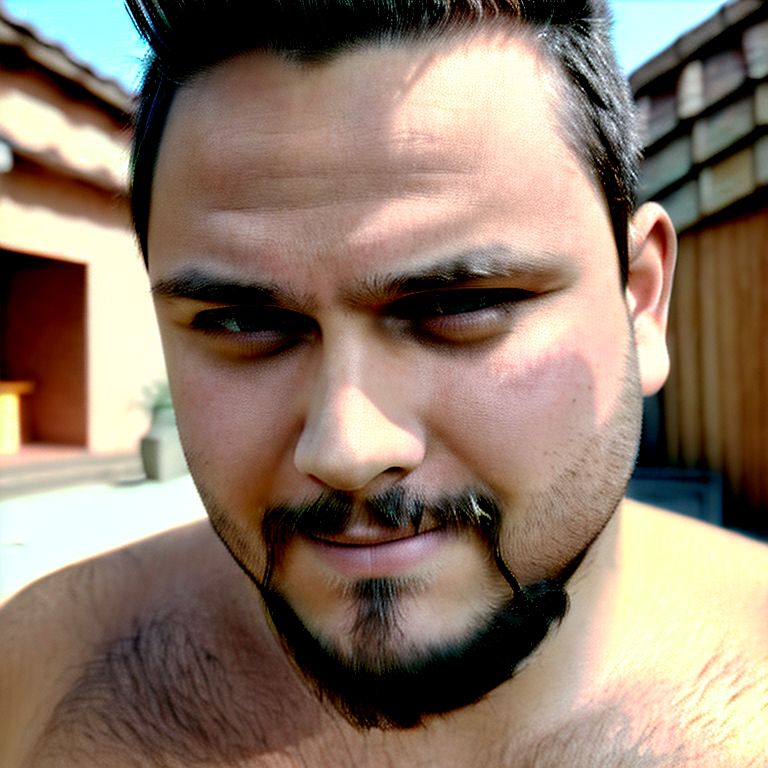

In [ ]:
# @title Run the Stable Diffusion pipeline on Colab

num_samples = 1
num_rows = 1

# Set Seed for Reproduction if intended
#generator = torch.Generator("cuda").manual_seed(3)


prompt = """Masterpiece photo of relu96 man, photo-realistic, sharp Focus,
realistic Textures, hd resolution, best quality,
extremely detailed, 8k wallpaper, highres, realistic"""

neg_prompt = """Ugly, Bad anatomy, Bad proportions, Bad quality, Blurry, Cropped,
Deformed, Disconnected limbs, Out of frame, Out of focus, Dehydrated, Error,
Disfigured, Disgusting, Extra arms, Extra limbs, Extra hands, Fused fingers,
Gross proportions, Long neck, Low res, Low quality, Jpeg artifacts, Malformed limbs,
Mutated, Mutated hands, Mutated limbs, Missing arms, Missing fingers, Picture frame,
Poorly drawn hands, Poorly drawn face, Text, Signature, Watermark, Worst quality,
Collage, Pixel, Pixelated, Grainy, canvas frame, high contrast, over saturated,
glossy, bad proportions, cloned face, gross proportions, malformed limbs, missing arms,
missing legs, extra arms, extra legs, fused fingers, too many fingers, tiling, deformed eyes,
poorly drawn eyes, mutated eyes, unrealistic Eyes, poorly drawn Beard, malformed Beard,
extra Toes, missing Toes, fused Toes, deformed Toes, mutated Toes, mutated Feet, 3d render,
cartoon, 3d, bad art, EasyNegative, paintings, sketches"""

all_images = []

for _ in range(num_rows):
    images = pipe(
        prompt,
        negative_prompt=neg_prompt,
        #generator = generator,
        num_images_per_prompt=num_samples,
        width = 768,
        height = 768,
        num_inference_steps=80,
        guidance_scale=7.5,
    ).images
    all_images.extend(images)
grid = display_images_as_grid(all_images, num_rows, num_samples)
grid


# Section 10. Sources and References

References:

Accelerator Documentation:

- https://huggingface.co/docs/accelerate/v0.27.2/en/package_reference/accelerator#accelerate.Accelerator

Optimizers:

- AdamW from Transformers:
https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.AdamW

- 8bitAdamW from bitsandbytes:
https://huggingface.co/docs/bitsandbytes/main/en/optimizers

Gradient Checkpointing:

- https://huggingface.co/docs/transformers/v4.18.0/en/performance

LR Schedulers:

- https://github.com/huggingface/transformers/blob/v4.37.2/src/transformers/trainer_utils.py#L394

- https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.get_scheduler

Noise Schedulers/ Schedulers in particular:

- DDIMSchedulers:
https://github.com/huggingface/diffusers/blob/v0.3.0/src/diffusers/schedulers/scheduling_ddim.py#L57

- DDPMScheduler:
https://github.com/huggingface/diffusers/blob/v0.3.0/src/diffusers/schedulers/scheduling_ddpm.py#L56

- PNDMScheduler:
https://github.com/huggingface/diffusers/blob/v0.3.0/src/diffusers/schedulers/scheduling_pndm.py#L56

Dataloader(Load Dataset/ how collate_fn works etc.):

- https://pytorch.org/docs/stable/data.html

Dreambooth(How does it work/ DreamboothDataset initialization):

- https://huggingface.co/docs/diffusers/training/dreambooth

mixed Precision von Accelerator:

- https://huggingface.co/docs/accelerate/v0.27.2/en/package_reference/accelerator#accelerate.Accelerator

Progressbar using tqdm: <br>
- https://tqdm.github.io/

UNet:
- https://huggingface.co/docs/diffusers/api/models/unet2d-cond

Autoencoder (Vae):
- https://huggingface.co/docs/diffusers/api/models/autoencoderkl

Feature extraction, tokenization and so on using Clip:
- https://huggingface.co/docs/transformers/model_doc/clip

Loss calculation using MSE Loss:
- https://pytorch.org/docs/stable/generated/torch.nn.functional.mse_loss.html

StableDiffusionPipelines:
- https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/overview

Der Code wurde Mithilfe von Black formatiert. Black folgt zum größten Teil dem
PEP8 Codestyle <br>
- https://black.readthedocs.io/en/stable/index.html

Models used are open access and available to all, with a CreativeML OpenRAIL-M license further specifying rights and usage:

- https://huggingface.co/spaces/CompVis/stable-diffusion-license
